In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from torchaudio import datasets

from loader import collate_function
from models import DSVAE

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
torch.mps.empty_cache()

Using device mps


In [4]:
def kld_with_any(mean_c, logvar_c, mean_wav, var_wav):
    return 0.5 * (
        torch.log(var_wav / logvar_c)
        + (logvar_c + (mean_c - mean_wav) ** 2) / var_wav
        - 1
    )


def kld_with_normal(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())


def recon_loss(x, recon_x):
    return F.mse_loss(recon_x, x)


def loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c):
    return (
        recon_loss(x, recon_x)
        + kld_with_normal(mean_s, logvar_s)
        + kld_with_normal(mean_c, logvar_c)
        # + kld_with_any(mean_c, logvar_c)
    )

In [5]:
train_data = datasets.VCTK_092("./", download=True)
train_data_loader = DataLoader(
    train_data,
    batch_size=2,
    collate_fn=lambda batch: collate_function(batch),
    sampler=RandomSampler(train_data, num_samples=100)
)

In [6]:
model = DSVAE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1
losses = []

In [7]:
torch.mps.empty_cache()
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_idx, (x, _) in enumerate(train_data_loader):
        x = x.to(device)
        optimizer.zero_grad()

        recon_x, mean_s, logvar_s, mean_c, logvar_c = model(x)
        loss = loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(train_data_loader)}")

    avg = train_loss / len(train_data_loader.dataset)
    losses.append(avg)

    print(f"Epoch {epoch+1}, Loss: {avg:.4f}")

print("Done!")

Epoch 1, Batch 1/50
Epoch 1, Batch 2/50
Epoch 1, Batch 3/50
Epoch 1, Batch 4/50
Epoch 1, Batch 5/50
Epoch 1, Batch 6/50
Epoch 1, Batch 7/50
Epoch 1, Batch 8/50
Epoch 1, Batch 9/50
Epoch 1, Batch 10/50
Epoch 1, Batch 11/50
Epoch 1, Batch 12/50
Epoch 1, Batch 13/50
Epoch 1, Batch 14/50
Epoch 1, Batch 15/50
Epoch 1, Batch 16/50
Epoch 1, Batch 17/50
Epoch 1, Batch 18/50
Epoch 1, Batch 19/50
Epoch 1, Batch 20/50
Epoch 1, Batch 21/50
Epoch 1, Batch 22/50
Epoch 1, Batch 23/50
Epoch 1, Batch 24/50
Epoch 1, Batch 25/50
Epoch 1, Batch 26/50
Epoch 1, Batch 27/50
Epoch 1, Batch 28/50
Epoch 1, Batch 29/50
Epoch 1, Batch 30/50
Epoch 1, Batch 31/50
Epoch 1, Batch 32/50
Epoch 1, Batch 33/50
Epoch 1, Batch 34/50
Epoch 1, Batch 35/50
Epoch 1, Batch 36/50
Epoch 1, Batch 37/50
Epoch 1, Batch 38/50
Epoch 1, Batch 39/50
Epoch 1, Batch 40/50
Epoch 1, Batch 41/50
Epoch 1, Batch 42/50
Epoch 1, Batch 43/50
Epoch 1, Batch 44/50
Epoch 1, Batch 45/50
Epoch 1, Batch 46/50
Epoch 1, Batch 47/50
Epoch 1, Batch 48/50
E

In [8]:
torch.save(model.state_dict, 'v5.pth')

In [9]:
def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)

    return mean + epsilon * std

def concat(z_s, z_c):
    concat_z = torch.cat((z_s, z_c), dim=1)
    return concat_z.unsqueeze(1)

In [15]:
z_s = reparameterize(mean_s, logvar_s)
z_c = reparameterize(mean_c, logvar_c)
concat_z = concat(z_s, z_c)
concat_z.shape

torch.Size([2, 1, 128])

In [22]:
o = model.decoder(concat_z)
oo = o.cpu().detach().numpy()

Text(0.5, 1.0, 'Mel Spectrogram')

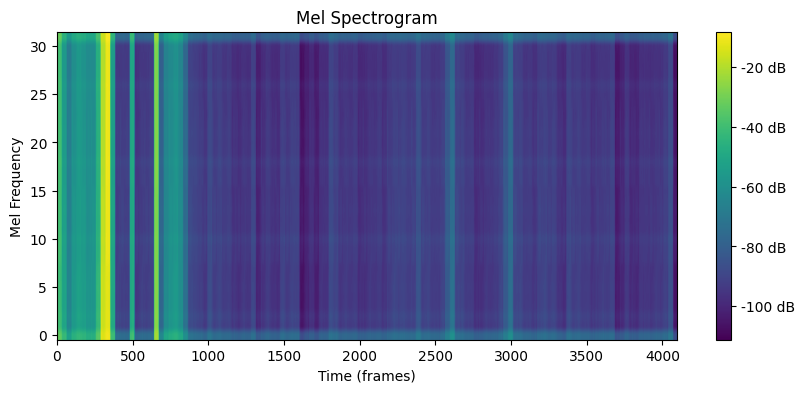

In [23]:
plt.figure(figsize=(10, 4))
plt.imshow(oo[0][0], aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Frequency")
plt.title("Mel Spectrogram")